## Prediction Vex-seq on training

In [1]:
import kipoi
from kipoi.model import KerasModel
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
from mmsplice.exon_dataloader import ExonDataset
from mmsplice.generic import get_var_side

from kipoi.data import DataLoader
from kipoi.data_utils import numpy_collate

from keras.models import load_model
from concise.preprocessing import encodeDNA

Using TensorFlow backend.
/opt/modules/i12g/anaconda/3-5.0.1/envs/splicing/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
%load_ext autoreload
%autoreload 2

from mmsplice.generic import logit, expit

def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

projectDIR = "../../data/"

In [4]:
dl = ExonDataset(projectDIR + "vexseq/HepG2_delta_PSI_CAGI_training.csv",
           projectDIR + "shared/hg19.fa", split_seq=False, overhang=(100,100))

In [5]:
dl[33]

{'inputs': {'seq': 'TCACAATTTGCTTGTTTTAAAATTTTCTTAATCTAGCAGTATAATTAGGTTCAAGTCAGATTTCAGATTTCTTCCCCTCCTCTCTTTTCACCTCTCACAGGCAAAGACTACCAAGCAGAAGCACGATGGCACGGTGGGCCTGCTCACATACCCAGTACTCCAGGCAGCCGACATTCTGTTGTACAAGTAAGAAGAGAGTTCAGCCCAGTCTTATACATACTCATGGTGACAAGAGAGTGTTTTAACCTATTCAATACAGACTTGGTTCATGGGCAAGGGGAAGTGC',
  'intronl_len': 100,
  'intronr_len': 100},
 'mut_inputs': {'seq': 'TCACAATTTGCTTGTTTTAAAATTTTCTTAATCTAGCAGTATAATTAGGTTCAAGTCAGATTTCAGATTTCTTCCCCTCCTCTCTTTTCACCTCTCACAGGCAAAGACTACCAAGCAGAAGCACGATGGCACGGTGGGCCTGCTCACATACCCAGTACTCCAGGCAGCCGACATTCTGTTGTACAAGTAAGAAGAGAGTTCAGCCAGTCTTATACATACTCATGGTGACAAGAGAGTGTTTTAACCTATTCAATACAGACTTGGTTCATGGGCAAGGGGAAGTGCA',
  'intronl_len': 100,
  'intronr_len': 100},
 'metadata': {'gene_id': '',
  'transcript_id': '',
  'biotype': '',
  'order': '',
  'ranges': GenomicRanges(chr='chr1', start=119584786, end=119585072, id='', strand='-')}}

In [6]:
dl = DataLoader(dl, batch_size=dl.__len__(), collate_fn=numpy_collate, shuffle=False)
dl = iter(dl)

In [7]:
dt = next(dl)

In [8]:
csv = projectDIR + "vexseq/HepG2_delta_PSI_CAGI_training.csv"
csvf = pd.read_csv(csv, sep=',')

In [9]:
csvf.head()

,ID,seqnames,start,end,width,strand,hg19_variant_position,reference,variant,HepG2_delta_psi,HepG2_ref_psi,CADD_PHRED,CADD_RAW,PhastCons,PhyloP
0,chr1_114161116_C_A,chr1,114161154,114161228,75,+,114161116,C,A,11.578092,48.884934,-8.376734,-1.642017,-0.471327,-1.415867
1,chr1_114161130_T_C,chr1,114161154,114161228,75,+,114161130,T,C,-4.362399,48.884934,-11.691734,-2.061542,-0.453327,-0.881867
2,chr1_114161136_AT_A,chr1,114161154,114161228,75,+,114161136,AT,A,2.054074,48.884934,0.000000,0.000000,-0.471327,-3.730867
3,chr1_114161147_C_T,chr1,114161154,114161228,75,+,114161147,C,T,-18.454982,48.884934,-10.807734,-1.897793,-0.471327,-2.361867
4,chr1_114161148_G_A,chr1,114161154,114161228,75,+,114161148,G,A,-21.979417,48.884934,-11.478734,-2.011739,-0.471327,-2.385867


In [10]:
csvf['side'] = list(map(get_var_side,
                         zip(csvf['hg19_variant_position'],
                             csvf['reference'],
                             csvf['variant'],
                             csvf['start'], csvf['end'],
                             csvf['strand'])))
csvf['REF_SEQ'] = dt['inputs']['seq']
csvf['ALT_SEQ'] = dt['mut_inputs']['seq']

In [11]:
csvf.to_csv(projectDIR + 'vexseq/HepG2_delta_PSI_CAGI_training_sided.csv')

## Prediction

### Train scaling factor

In [12]:
from mmsplice import MMSplice, predict_all, writeVCF, predict_all_table

In [13]:
model = MMSplice(
    exon_cut_l=0,
    exon_cut_r=0,
    acceptor_intron_cut=6,
    donor_intron_cut=6,
    acceptor_intron_len=50,
    acceptor_exon_len=3,
    donor_exon_len=5,
    donor_intron_len=13)

/opt/modules/i12g/anaconda/3-5.0.1/envs/splicing/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [14]:
ref_pred = model.predict_on_unsplitted_batch(dt['inputs'])

alt_pred = model.predict_on_unsplitted_batch(dt['mut_inputs'])

/opt/modules/i12g/anaconda/3-5.0.1/envs/splicing/lib/python3.6/site-packages/mmsplice-0.2.0-py3.6.egg/mmsplice/mmsplice.py:153: UserWarning: None GT donor
  warnings.warn("None GT donor", UserWarning)
/opt/modules/i12g/anaconda/3-5.0.1/envs/splicing/lib/python3.6/site-packages/mmsplice-0.2.0-py3.6.egg/mmsplice/mmsplice.py:155: UserWarning: None AG donor
  warnings.warn("None AG donor", UserWarning)


In [15]:
X = alt_pred-ref_pred

In [16]:
ref_psi = (csvf.HepG2_ref_psi/100.).as_matrix()

delt_measured = csvf.HepG2_delta_psi.as_matrix().flatten()/100.

y = logit(ref_psi + delt_measured) - logit(ref_psi)

/opt/modules/i12g/anaconda/3-5.0.1/envs/splicing/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/opt/modules/i12g/anaconda/3-5.0.1/envs/splicing/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


## Build assembly model

### Just sum scores

In [17]:
delt_pred = X.sum(1)
delt_pred += logit(ref_psi)
delt_pred = expit(delt_pred)
delt_pred -= ref_psi
r = pearsonr(delt_pred, delt_measured)[0]
print(r)
print(spearmanr(delt_pred, delt_measured))

0.6642463358510119
SpearmanrResult(correlation=0.415125741484872, pvalue=3.702258608493261e-41)


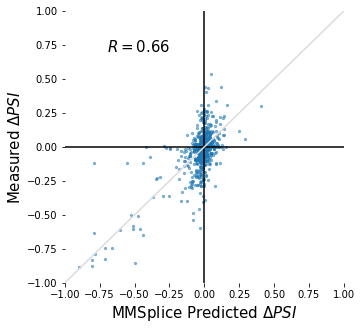

In [18]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.axis([-1,1,-1,1])
ax.scatter(delt_pred, delt_measured, s=5, alpha=0.5)
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.set_xlabel("MMSplice Predicted $\Delta PSI$", fontsize=15)
ax.set_ylabel("Measured $\Delta PSI$", fontsize=15)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.7,0.7,'$R=%0.2f$'%r,fontsize=15)
add_identity(ax, color="#DCDCDC")
plt.show()

### With Huber regression

In [19]:
exon_overlap = np.logical_or(np.logical_and(X[:,1]!=0, X[:,2]!=0), np.logical_and(X[:,2]!=0, X[:,3]!=0))
acceptor_overlap = np.logical_and(X[:,1]!=0, X[:,2]!=0)
donor_overlap = np.logical_and(X[:,2]!=0, X[:,3]!=0)

acceptor_intron_overlap = np.logical_and(X[:,0]!=0, X[:,1]!=0)
donor_intron_overlap = np.logical_and(X[:,3]!=0, X[:,4]!=0)

# Interaction
X = np.hstack([X, (X[:,2]*exon_overlap).reshape(-1,1)]) # Exon overlap donor and acceptor
X = np.hstack([X, (X[:,4]*donor_intron_overlap).reshape(-1,1)]) # Donor intron overlap donor * f_(donor_intron)
X = np.hstack([X, (X[:,0]*acceptor_intron_overlap).reshape(-1,1)]) # Acceptor intron overlap acceptor * f_{acceptor_intron}

In [20]:
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import cross_val_predict, GridSearchCV

In [21]:
huber = HuberRegressor(fit_intercept=True, alpha=0.0, max_iter=100, epsilon=1)
huber.fit(X, y)
from sklearn.externals import joblib
joblib.dump(huber, projectDIR+'vexseq/scale_model.pkl')

['../../data/vexseq/scale_model.pkl']

In [22]:
# delt_pred = np.dot(X, huber.coef_) + huber.intercept_
delt_pred = huber.predict(X)

In [23]:
delt_pred += logit(ref_psi)
delt_pred = expit(delt_pred)
delt_pred -= ref_psi

In [24]:
r = pearsonr(delt_pred, delt_measured)[0]
r

0.6851261712219985

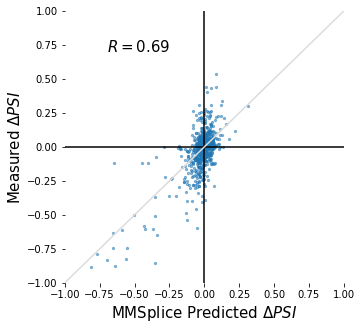

In [25]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.axis([-1,1,-1,1])
ax.scatter(delt_pred, delt_measured, s=5, alpha=0.5)
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.set_xlabel("MMSplice Predicted $\Delta PSI$", fontsize=15)
ax.set_ylabel("Measured $\Delta PSI$", fontsize=15)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.7,0.7,'$R=%0.2f$'%r,fontsize=15)
add_identity(ax, color="#DCDCDC")
plt.show()

In [26]:
csvf["Huber_Pred"] = delt_pred

## Predict only with exon module

In [27]:
import mmsplice
from mmsplice.generic import onehot
# import keras.backend as K
# K.clear_session()
from keras.models import load_model

In [28]:
exonM5 = load_model(mmsplice.EXON)
exonM3 = load_model(mmsplice.EXON3)

/opt/modules/i12g/anaconda/3-5.0.1/envs/splicing/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [29]:
exon = csvf[csvf.side.isnull()]
exon_ref = exon.REF_SEQ.apply(lambda x: x[100:-100])
exon_alt = exon.ALT_SEQ.apply(lambda x: x[100:-100])

ref_psi = (exon.HepG2_ref_psi/100.).values
dPsi_measured = (exon.HepG2_delta_psi/100.).values

In [30]:
def apply_exonM(exonM):
    exon_ref_pred = exon_ref.apply(lambda x: exonM.predict(encodeDNA([x]))[0])
    exon_alt_pred = exon_alt.apply(lambda x: exonM.predict(encodeDNA([x]))[0])
    exon_delta = exon_alt_pred.values - exon_ref_pred.values
    exon_delta = np.concatenate(exon_delta)
    dPsi = expit(logit(ref_psi) + exon_delta) - ref_psi
    return dPsi

In [31]:
dPsi5 = apply_exonM(exonM5)
dPsi3 = apply_exonM(exonM3)

In [32]:
np.savetxt(projectDIR + "vexseq/Exon_Pred_Prime5.txt", np.stack([dPsi5, dPsi_measured]).T)
np.savetxt(projectDIR + "vexseq/Exon_Pred_Prime3.txt", np.stack([dPsi3, dPsi_measured]).T)